In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [6]:
N = 200

X = np.random.uniform(low=-50, high=50, size=(N, 1))
T = 3.2*X + np.random.normal(size=(N, 1), scale=5.5)

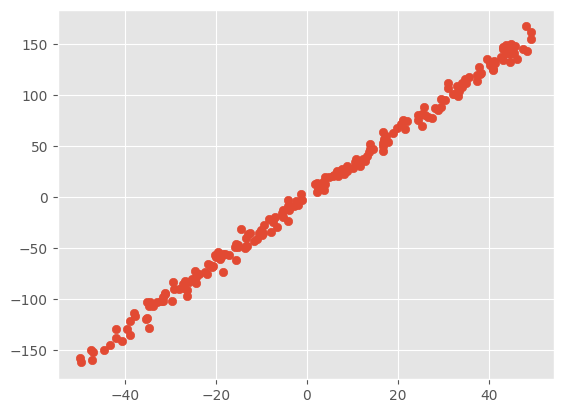

In [3]:
plt.scatter(X,T)

In [4]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    
    return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [5]:
class MCElbo(torch.nn.Module):
    def __init__(self):
        super(MCElbo, self).__init__()
        self.n_latent = 100 # Number of latent samples
        self.softplus = torch.nn.Softplus()
        
        #The parameters we adjust during training.
        self.qm = torch.nn.Parameter(torch.randn(1,1), requires_grad=True)
        self.qs= torch.nn.Parameter(torch.randn(1,1), requires_grad=True)
        
        #create holders for prior mean and std, and likelihood std.
        self.prior_m = Variable(torch.randn(1,1), requires_grad=False)
        self.prior_s = Variable(torch.randn(1,1), requires_grad=False)
        self.likelihood_s = Variable(torch.FloatTensor((1)), requires_grad=False)
        
        #Set the prior and likelihood moments.
        self.prior_s.data.fill_(1.0)
        self.prior_m.data.fill_(0.9)
        self.likelihood_s.data.fill_(5.5)
     
        
    def generate_rand(self):
        return np.random.normal(size=(self.n_latent,1))
    
    def reparam(self, eps):
        eps = Variable(torch.FloatTensor(eps))
        return  eps.mul(self.softplus(self.qs)).add(self.qm)
    
    def compute_elbo(self, x, t):
        eps = self.generate_rand()
        z = self.reparam(eps)
        q_likelihood = torch.mean(log_norm(z, self.qm, self.softplus(self.qs)))
        prior = torch.mean(log_norm(z, self.prior_m, self.prior_s))
        likelihood = torch.mean(torch.sum(log_norm(t, x*z.transpose(0,1), 
                                                   self.likelihood_s), 0))
        
        kld_mc = q_likelihood - prior
        loss = likelihood - kld_mc
        return loss

In [6]:
c = MCElbo()
optimizer = torch.optim.Adam(c.parameters(),lr=0.2)
x = Variable(torch.Tensor(X), requires_grad=False) 
t = Variable(torch.Tensor(T), requires_grad=False)

for i in range(2001):
    loss = -c.compute_elbo(x, t)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    if i % 250 ==0:
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

[[-1.1820168]] [[0.3188484]]
[[3.1989334]] [[0.00096181]]
[[3.1961288]] [[0.00042999]]
[[3.1977522]] [[0.00028171]]
[[3.1971877]] [[0.00022459]]
[[3.1973608]] [[0.00019988]]
[[3.1972206]] [[0.00018828]]
[[3.1988037]] [[0.00018201]]
[[3.19883]] [[0.00018279]]


In [7]:
analytical_posterior_var = ((1/5.5**2)*X.T@ X +1)**-1
analytical_posterior_var

array([[0.00020568]])

In [8]:
analytical_posterior_mean = analytical_posterior_var*(0.9+((1/5.5**2)*X.T @ T))
analytical_posterior_mean

array([[3.19765981]])

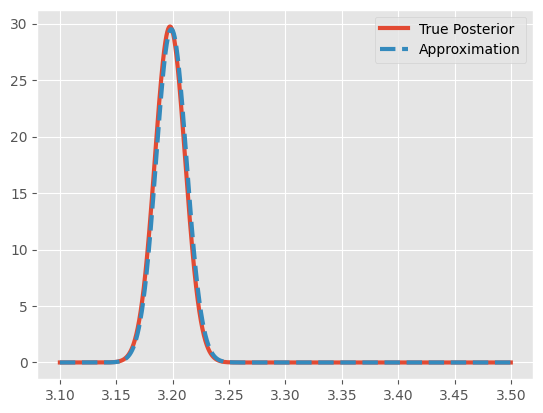

In [9]:
from scipy.stats import norm
xn = np.arange(3.1, 3.5, 0.0001)
true_dist = norm(loc = analytical_posterior_mean, 
                 scale =(analytical_posterior_var)**0.5)
q_dist = norm(loc = c.qm.data.numpy(), scale = c.softplus(c.qs).data.numpy())
yn = true_dist.pdf(xn).ravel()
plt.plot(xn, yn, linewidth=3, label="True Posterior")
plt.plot(xn, q_dist.pdf(xn).ravel(), '--', linewidth=3,
         label="Approximation")
plt.legend()